In [91]:
library(edgeR)
library(limma)
library(Glimma)
library(gplots)
library(RColorBrewer)
library(ggplot2)
library(repr)
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=100)

In [44]:
## Read the counts from the concatenated data
seqdata <- read.csv("LOX_parental_cell_vs_MV.csv", header=TRUE)

In [45]:
head(seqdata)
dim(seqdata)

X,PcelA,PcelB,PcelC,PMVA,PMVB,PMVC
hsa-let-7a-5p,39725,32477,48353,15461,23769,21061
hsa-let-7a-3p,514,370,608,43,67,68
hsa-let-7a-2-3p,25,17,46,3,10,11
hsa-let-7b-5p,706,500,750,450,714,695
hsa-let-7b-3p,32,22,40,10,15,22
hsa-let-7c-5p,740,540,836,393,508,630


[1] 2657    7

In [46]:
countdata <- seqdata[ , -1 ]
rownames( countdata ) <- seqdata[ , 1 ] # miRNA gene names
colnames( countdata ) <- colnames(seqdata) [-1]

In [47]:
# The cols in countdata
colnames(countdata)

[1] "PcelA" "PcelB" "PcelC" "PMVA"  "PMVB"  "PMVC"

In [48]:
# Use cpm to filter out the low expressed genes
CPM <- cpm(countdata)
head(CPM)

,PcelA,PcelB,PcelC,PMVA,PMVB,PMVC
hsa-let-7a-5p,31673.82932,31401.68084,32409.06754,39094.858322,37278.97515,43801.61680
hsa-let-7a-3p,409.82626,357.74924,407.51790,108.730283,105.08189,141.42301
hsa-let-7a-2-3p,19.93318,16.43713,30.83195,7.585834,15.68386,22.87725
hsa-let-7b-5p,562.91312,483.44491,502.69478,1137.875056,1119.82785,1445.42632
hsa-let-7b-3p,25.51448,21.27158,26.81039,25.286112,23.52580,45.75450
hsa-let-7c-5p,590.02225,522.12051,560.33711,993.744216,796.74027,1310.24256


In [49]:
thresh <- CPM > 3
head(thresh, 10)

,PcelA,PcelB,PcelC,PMVA,PMVB,PMVC
hsa-let-7a-5p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7a-3p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7a-2-3p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7b-5p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7b-3p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7c-5p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7c-3p,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
hsa-let-7d-5p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7d-3p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
hsa-let-7e-5p,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


In [50]:
table(rowSums(thresh))


   0    1    2    3    4    5    6 
1864  149   97   74   55   49  369 

In [51]:
keep <- rowSums(thresh) >= 2
summary(keep)

   Mode   FALSE    TRUE 
logical    2013     644 

In [52]:
counts.keep <- countdata[keep,]
dim(counts.keep)

[1] 644   6

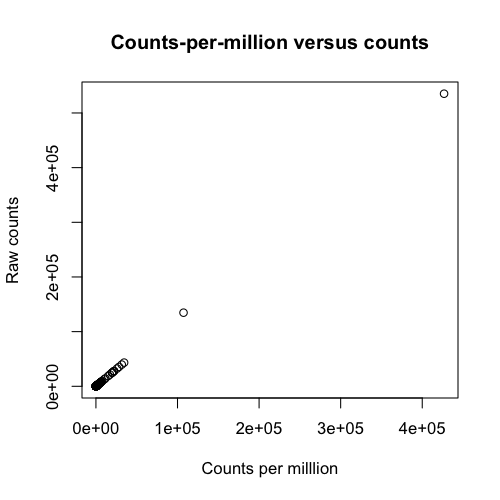

In [53]:
# Let's have a look and see whether our threshold of 0.5 does indeed correspond to a count of about 10-15
# We will look at the first sample
plot(CPM[,1],countdata[,1], xlab = "Counts per milllion", ylab = "Raw counts", mar = "*", type = "p",
     main="Counts-per-million versus counts",)

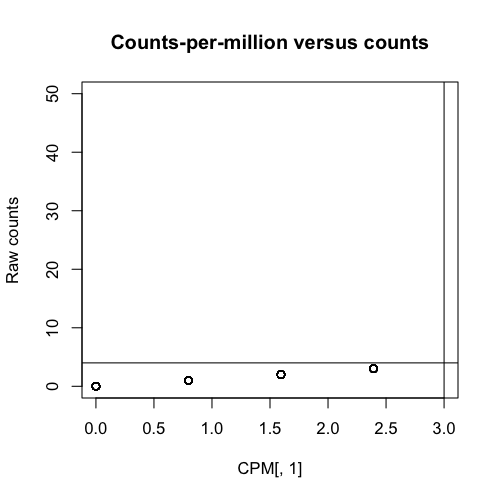

In [92]:
plot(CPM[,1],countdata[,1],ylim=c(0,50),xlim=c(0,3), 
     ylab = "Raw counts", mar = "*", type = "p", main="Counts-per-million versus counts",)
abline(h = 4)
abline(v = 3)
# This means for cellular samples, basically filtered out miRNAs less than 4 counts

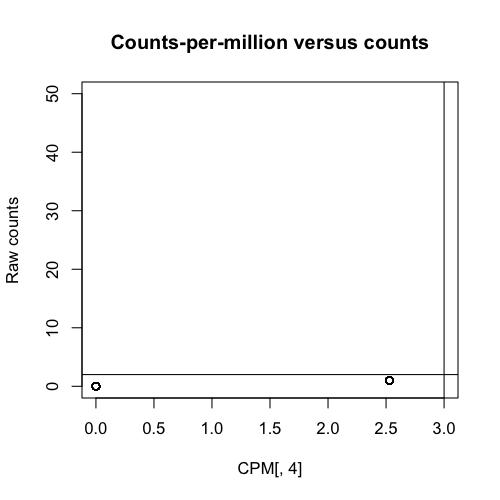

In [93]:
plot(CPM[,4],countdata[,4],ylim=c(0,50),xlim=c(0,3), 
     ylab = "Raw counts", mar = "*", type = "p", main="Counts-per-million versus counts",)
abline(h = 2)
abline(v = 3)
# This means for MV samples, basically filtered out miRNAs raw counts less than 2

In [135]:
# Set group Cells vs MVs
group <- c(rep(0, 3), rep(1, 3))

# Make dge list and set group
dge <- DGEList(counts.keep)
dge$samples$group <- group 

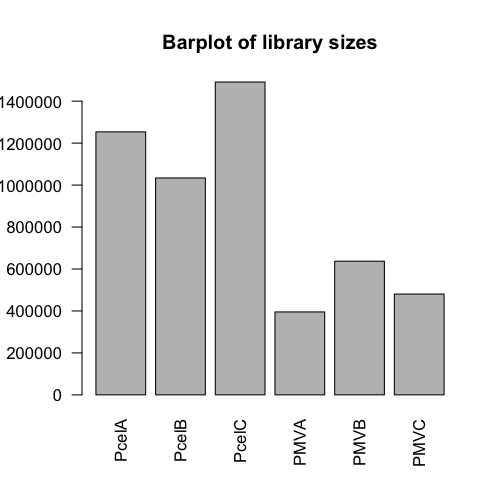

In [136]:
barplot(dge$samples$lib.size, names=colnames(dge), las=2)
title("Barplot of library sizes")

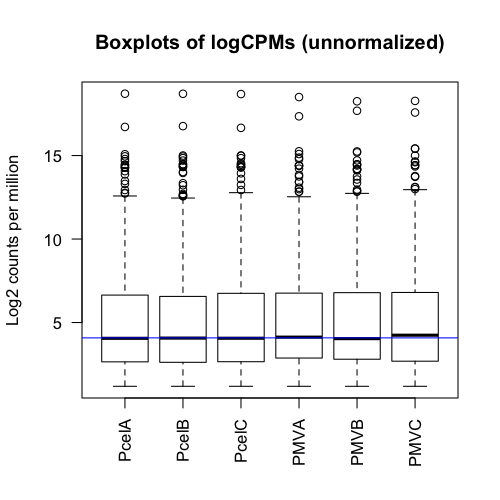

In [137]:
# Get log2 counts per million
logcounts <- cpm(dge,log=TRUE)

# Check distributions of samples using boxplots
boxplot(logcounts, xlab="", ylab="Log2 counts per million",las=2)
# Let's add a blue horizontal line that corresponds to the median logCPM
abline(h=median(logcounts),col="blue")
title("Boxplots of logCPMs (unnormalized)")

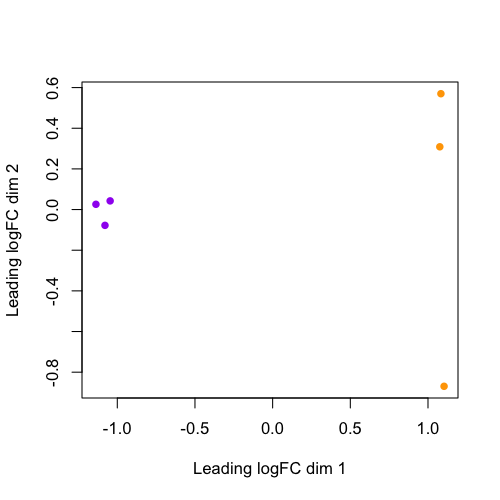

In [138]:
# Set up types variable as argument for downstream analysis
types <- c(rep("LOX cell", 3), rep("LOX TMV", 3))
## Purple for Cell and orange for MV
col <- c(rep("purple", 3), rep("orange", 3))

# Make a mds plot with plotMDS from edgeR to reduce demensions of the data
cds <- DGEList(counts=countdata)
cds <- calcNormFactors(cds)
mds <- plotMDS(cds, top=200, col=col, pch = 16)

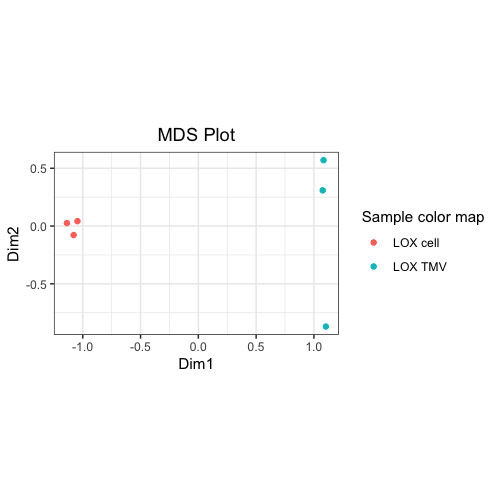

In [140]:
# Change it to ggplot style plot
toplot <- data.frame(Dim1 = mds$x, Dim2 = mds$y, Group = types)
library(ggplot2)
p <- ggplot(toplot, aes(Dim1, Dim2, colour = Group)) + geom_point() +theme_bw() + ggtitle("MDS Plot")+
coord_fixed(ratio = 1) + guides(colour=guide_legend(title="Sample color map")) + theme(plot.title = element_text(hjust = 0.5))
p

In [141]:
# Performed the PCA and compare to MDS from edgeR
pca <- prcomp(t(countdata))
pca.var <- pca$sdev^2
pca.var.per <- round(pca.var/sum(pca.var)*100,1)

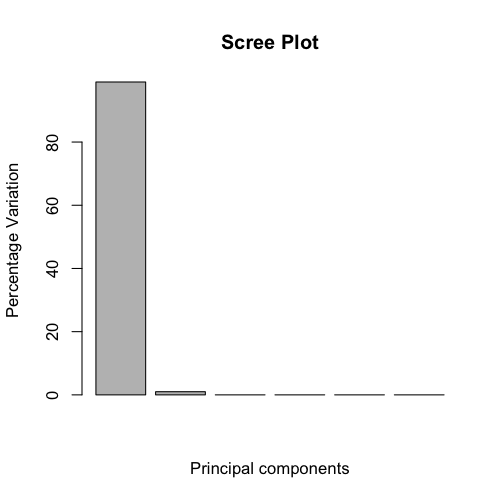

In [142]:
# Plot to what percentage variation each PC account to
barplot(pca.var.per, main = "Scree Plot", xlab = "Principal components", ylab = "Percentage Variation" )

In [143]:
# Extract PC1 and PC2 from the pca
pca.data <- data.frame(Sample=rownames(pca$x), X=pca$x[,1], Y=pca$x[,2])
pca.data

,Sample,X,Y
PcelA,PcelA,-188799.53,-3419.487
PcelB,PcelB,-90263.43,-12430.665
PcelC,PcelC,-284911.94,5772.128
PMVA,PMVA,212024.33,-27239.019
PMVB,PMVB,149843.57,36158.828
PMVC,PMVC,202107.00,1158.214


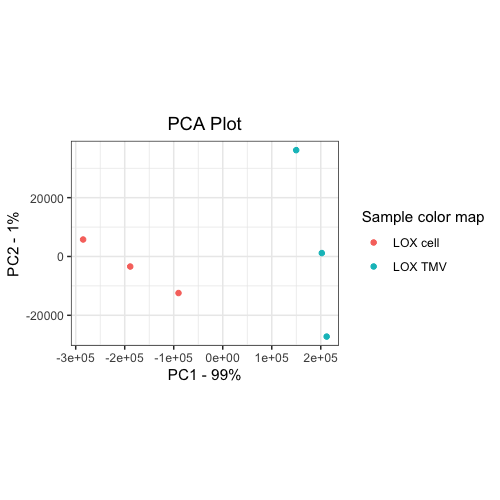

In [147]:
# Plot the PCA
p <- ggplot(data=pca.data, aes(x=X,y=Y, colour = types), size=20) +
geom_point() +
xlab(paste("PC1 - ", pca.var.per[1], "%", sep="")) +
ylab(paste("PC2 - ", pca.var.per[2], "%", sep="")) +
theme_bw() + ggtitle("PCA Plot") + coord_fixed(ratio = 6) + guides(colour=guide_legend(title="Sample color map")) + theme(plot.title = element_text(hjust = 0.5))
p

In [3]:
# Clearly the miRNA profiles of cells and MVs are seperated on the graph

In [148]:
# Estimate the variance for each row in the logcounts matrix
var_genes <- apply(logcounts, 1, var)
head(var_genes)


hsa-let-7a-5p   hsa-let-7a-3p hsa-let-7a-2-3p   hsa-let-7b-5p   hsa-let-7b-3p 
      0.0383468       0.9101164       0.3472809       0.4884386       0.1311140 
  hsa-let-7c-5p 
      0.2764598

In [149]:
# Get the gene names for the top 100 most variable genes
select_var <- names(sort(var_genes, decreasing=TRUE))[1:100]
head(select_var)

[1] "hsa-miR-4521"  "hsa-miR-7974"  "hsa-miR-4488"  "hsa-miR-7704" 
[5] "hsa-miR-3135b" "hsa-miR-12135"

In [150]:
# Subset logcounts matrix
highly_variable_lcpm <- logcounts[select_var,]
dim(highly_variable_lcpm)
head(highly_variable_lcpm)


[1] 100   6

,PcelA,PcelB,PcelC,PMVA,PMVB,PMVC
hsa-miR-4521,9.328235,9.240454,9.244194,2.262164,1.939888,1.181149
hsa-miR-7974,7.832958,7.981755,7.987104,1.181149,1.181149,2.120496
hsa-miR-4488,3.464935,3.012751,2.653253,9.151988,8.996287,9.561363
hsa-miR-7704,5.502784,5.716006,5.600958,10.545633,11.448849,10.594574
hsa-miR-3135b,2.818370,3.012751,2.932048,7.780097,8.401193,7.916277
hsa-miR-12135,6.286273,6.350167,6.286126,1.181149,1.181149,1.181149


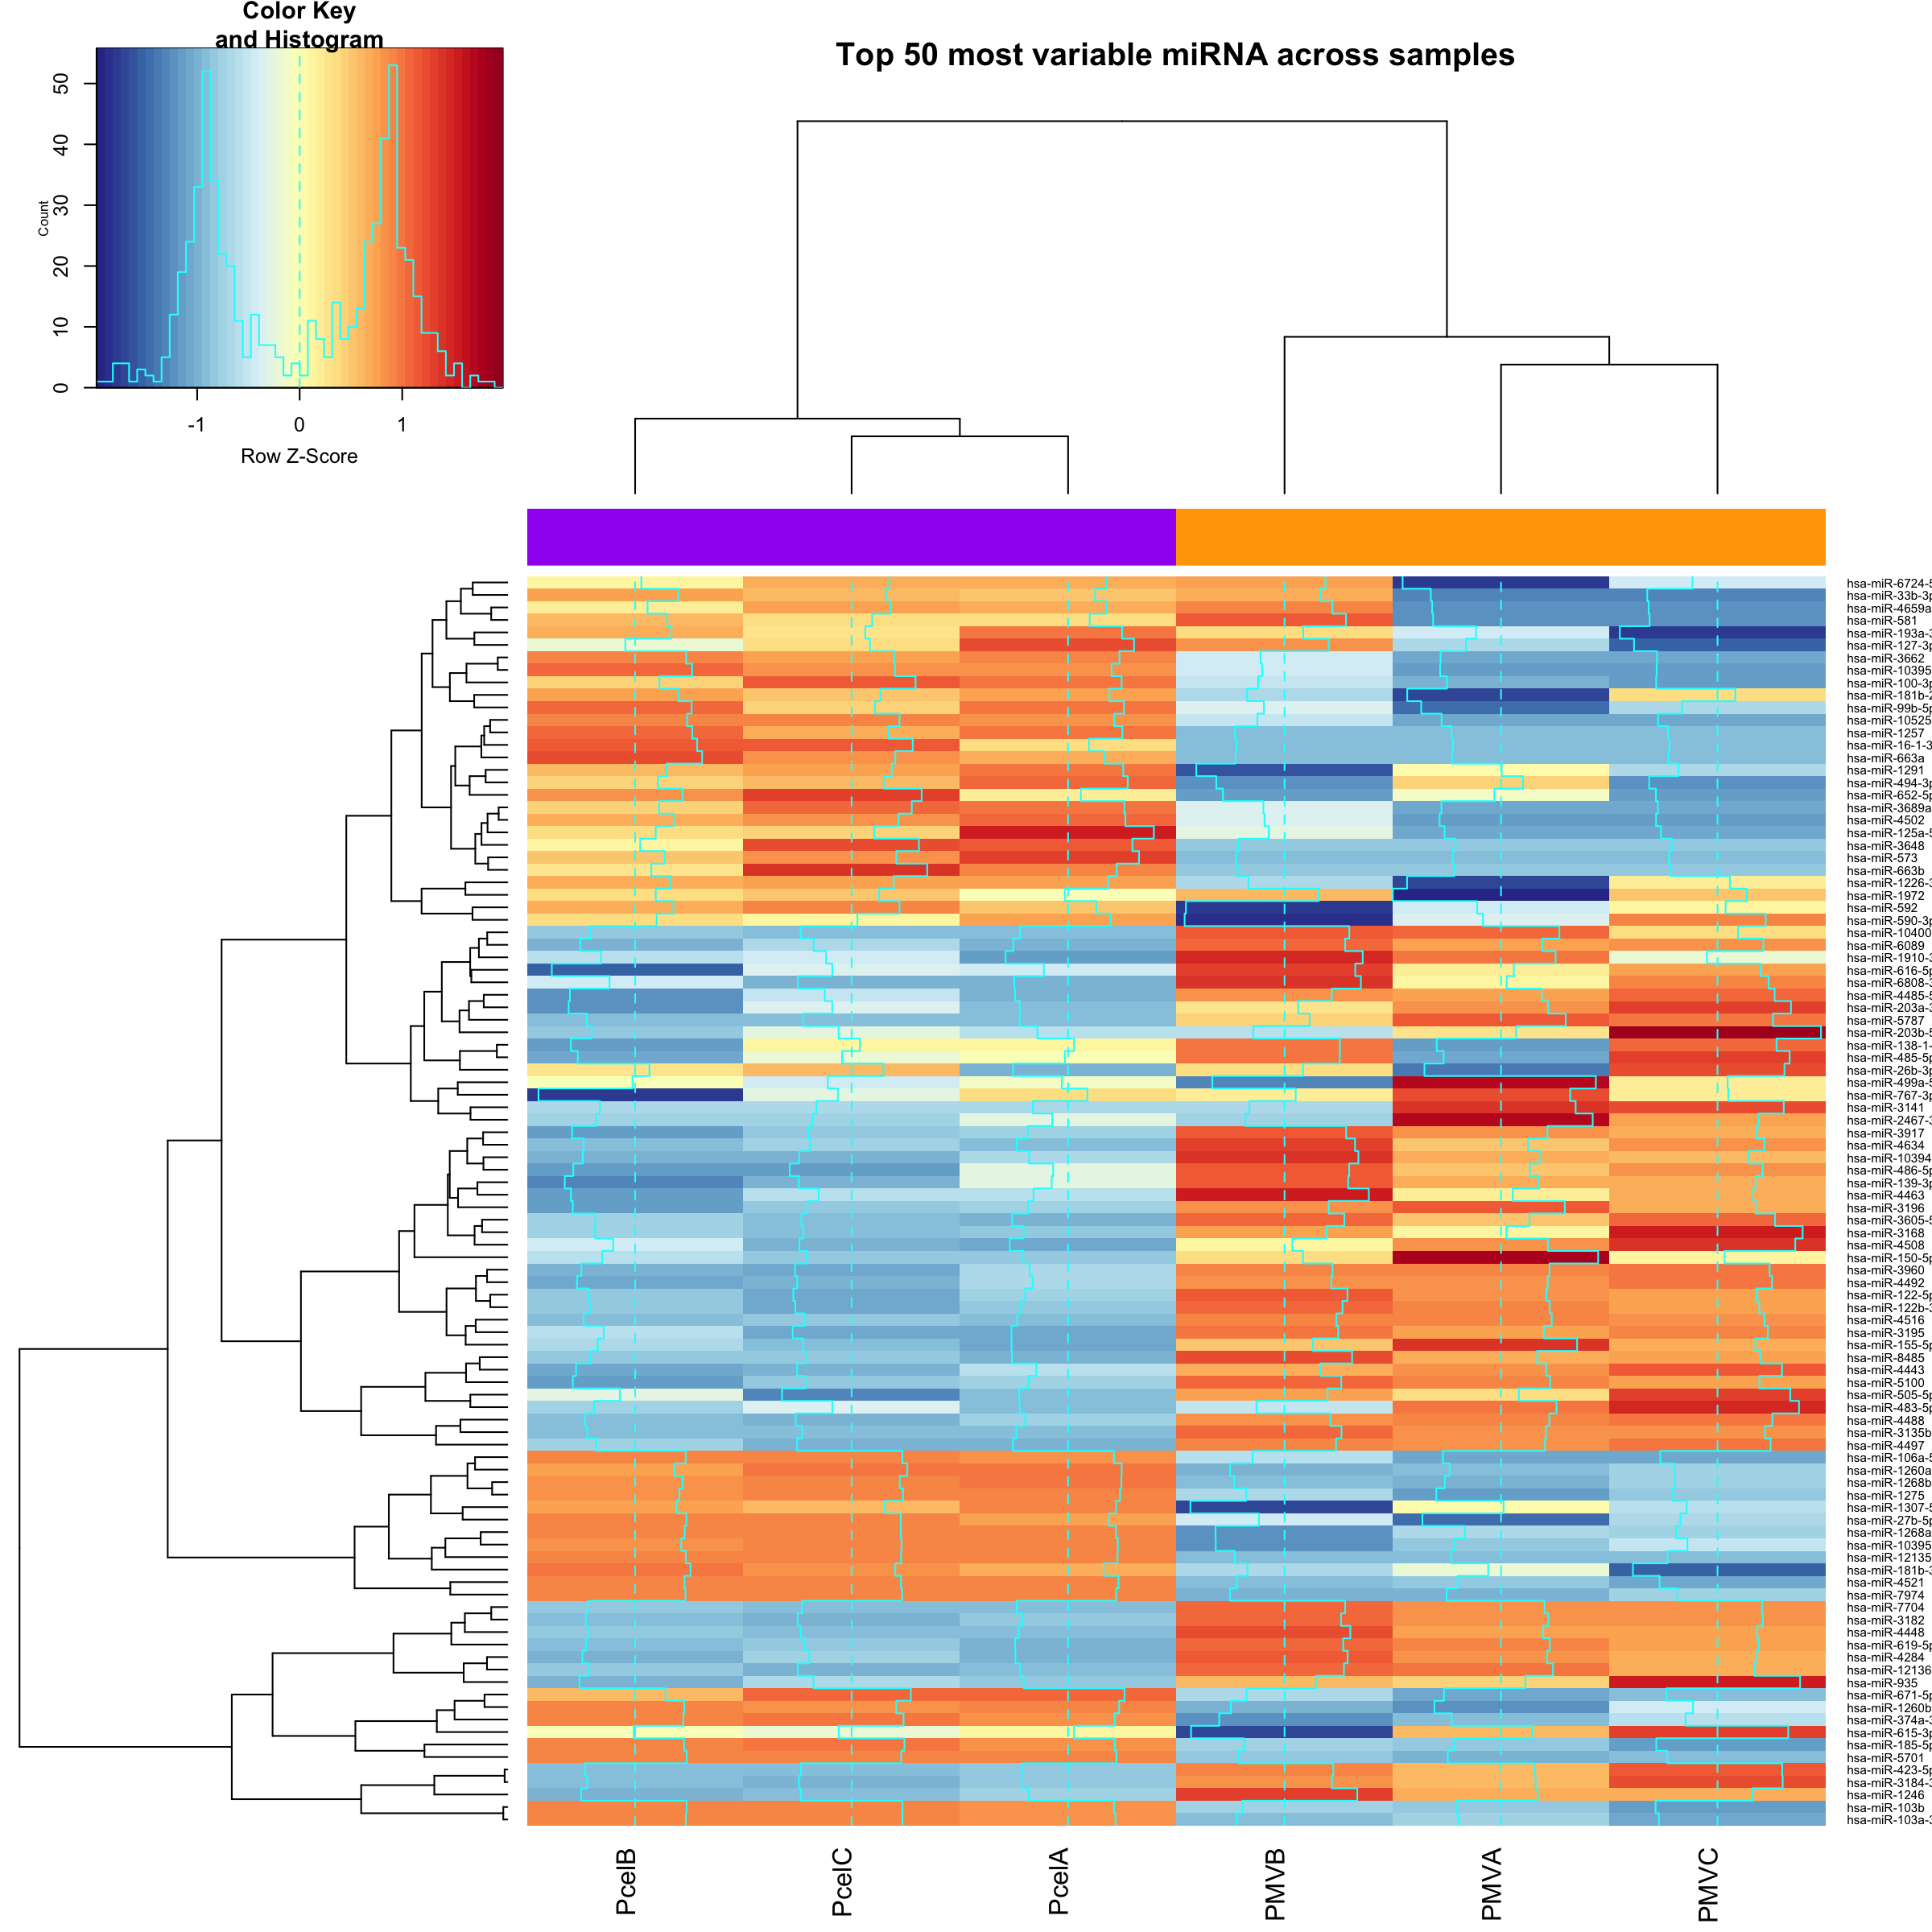

In [151]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res=200)
# Get some nicer colours
mypalette <- brewer.pal(11,"RdYlBu")
morecols <- colorRampPalette(mypalette)

# Plot the heatmap
heatmap.2(highly_variable_lcpm, 
          col=rev(morecols(50)),
          trace="column", 
          main="Top 50 most variable miRNA across samples",
          ColSideColors=col,scale="row")

In [152]:
# Set the plot size back
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=100)

In [153]:
dge_norm <- calcNormFactors(dge)
dge_norm$samples

,group,lib.size,norm.factors
PcelA,0,1253631,0.9404985
PcelB,0,1033864,0.9194673
PcelC,0,1491318,0.9581561
PMVA,1,395328,1.0544208
PMVB,1,637270,1.0333362
PMVC,1,480568,1.1076785


In [4]:

# Specify a design matrix with an intercept term
group <- as.character(group)
type <- sapply(strsplit(group, ".", fixed=T), function(x) x[1])

design <- model.matrix(~ type)
design

ERROR: Error in eval(expr, envir, enclos): object 'group' not found


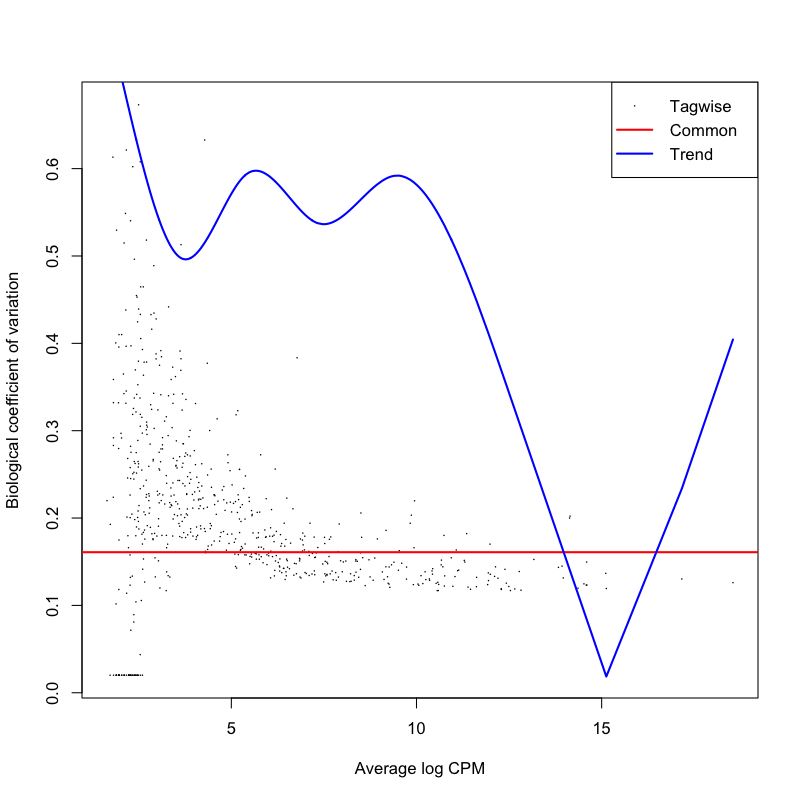

In [161]:
# This is the dispersion test
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=100)
dge_est_comm_disp <- estimateCommonDisp(dge_norm)
dge_trend_disp <- estimateGLMTrendedDisp(dge_est_comm_disp)
dge_tagwise_disp <- estimateTagwiseDisp(dge_trend_disp)
plotBCV(dge_tagwise_disp)
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=100)

In [167]:
# Fit the data with glm model glmFit from edgeR
fit <- glmFit(dge_tagwise_disp, design)
names(fit)

[1] "coefficients"          "fitted.values"         "deviance"             
 [4] "method"                "counts"                "unshrunk.coefficients"
 [7] "df.residual"           "design"                "offset"               
[10] "dispersion"            "prior.count"           "samples"              
[13] "prior.df"              "AveLogCPM"

In [168]:
head(coef(fit))

,(Intercept),type1
hsa-let-7a-5p,-3.384374,0.1031841
hsa-let-7a-3p,-7.781627,-1.3242137
hsa-let-7a-2-3p,-10.625272,-0.4867968
hsa-let-7b-5p,-7.505481,0.7433976
hsa-let-7b-3p,-10.542057,0.1099192
hsa-let-7c-5p,-7.428934,0.4857608


In [169]:
# Get the different expression profile with glmLRT from edgeR
DE <- glmLRT(fit, coef=2)

In [171]:
topTags(DE)

,logFC,logCPM,LR,PValue,FDR
hsa-miR-4521,-8.882130,8.440294,549.9786,1.272439e-121,8.194510e-119
hsa-miR-4488,6.423788,8.091394,507.2839,2.472679e-112,7.962028e-110
hsa-miR-5701,-4.368221,8.829854,403.5250,9.410095e-90,2.020034e-87
hsa-miR-3182,4.641778,9.534222,383.9144,1.748851e-85,2.815650e-83
hsa-miR-4497,4.439212,8.024208,347.4561,1.517472e-77,1.954504e-75
hsa-miR-7974,-8.395025,7.178332,328.1296,2.455684e-73,2.635768e-71
hsa-miR-7704,5.212947,9.861972,305.8067,1.789467e-68,1.646309e-66
hsa-miR-3135b,5.442237,6.867515,275.2170,8.277942e-62,6.663744e-60
hsa-miR-185-5p,-2.908477,9.732063,220.1390,8.434540e-50,6.035382e-48
hsa-miR-3960,5.746728,5.399468,201.2793,1.098153e-45,7.072106e-44


In [173]:
# Save the DE to a Rdata file
save(DE,dge_tagwise_disp,group,file="Differential_analysis_results/DE.Rdata")

In [184]:
# Save the genes with different FC and p-adj to a file for downstream analysis
out <- topTags(DE, n=Inf)
write.csv(out, file="Differential_analysis_results/LOX_cell_vs_LOX_TMV.csv")